<a href="https://colab.research.google.com/github/PalakAggarwal13/DL_Projects/blob/main/Project_1_AI_Powered_Drug_Discovery_and_Development/AI_Powered_Drug_Discovery_and_Development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
drugs = pd.read_csv('https://raw.githubusercontent.com/dingyan20/Davis-Dataset-for-DTA-Prediction/main/drugs.csv')
proteins = pd.read_csv('https://raw.githubusercontent.com/dingyan20/Davis-Dataset-for-DTA-Prediction/main/proteins.csv')
affinity = pd.read_csv('https://raw.githubusercontent.com/dingyan20/Davis-Dataset-for-DTA-Prediction/main/drug_protein_affinity.csv')

print("drugs.columns:", drugs.columns.tolist())
print("proteins.columns:", proteins.columns.tolist())
print("affinity.columns:", affinity.columns.tolist())


drugs.columns: ['Drug_Index', 'CID', 'Canonical_SMILES', 'Isomeric_SMILES']
proteins.columns: ['Protein_Index', 'Accession_Number', 'Gene_Name', 'Sequence']
affinity.columns: ['Drug_Index', 'Protein_Index', 'Affinity']


In [18]:
drugs = drugs.rename(columns={
    'Drug_Index': 'drug_id',
    'Canonical_SMILES': 'drug_smiles'
})

proteins = proteins.rename(columns={
    'Protein_Index': 'target_id',
    'Sequence': 'protein_seq'
})

affinity = affinity.rename(columns={
    'Drug_Index': 'drug_id',
    'Protein_Index': 'target_id',
    'Affinity': 'affinity'
})

df = pd.merge(affinity, drugs[['drug_id', 'drug_smiles']], on='drug_id')

df = pd.merge(df, proteins[['target_id', 'protein_seq']], on='target_id')

df = df[['drug_id', 'drug_smiles', 'target_id', 'protein_seq', 'affinity']]
df.head()

,drug_id,drug_smiles,target_id,protein_seq,affinity
0,0,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,0,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,7.366532
1,0,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,1,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,5.000000
2,0,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,3,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,5.000000
3,0,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,5,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,5.000000
4,0,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,7,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,5.000000


In [13]:
le_drug = LabelEncoder()
le_target = LabelEncoder()

df['drug_encoded'] = le_drug.fit_transform(df['drug_smiles'])
df['target_encoded'] = le_target.fit_transform(df['protein_seq'])

X = df[['drug_encoded', 'target_encoded']].values
y = df['affinity'].values.reshape(-1, 1)

scaler = StandardScaler()
y = scaler.fit_transform(y)

In [14]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
histories = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Training Fold {fold+1}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = build_model()
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=50, batch_size=32, verbose=0)
    histories.append(history)

Training Fold 1
Training Fold 2
Training Fold 3
Training Fold 4
Training Fold 5


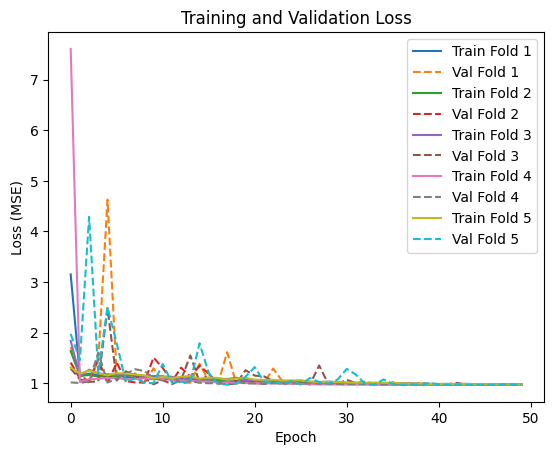

In [16]:
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f'Train Fold {i+1}')
    plt.plot(history.history['val_loss'], label=f'Val Fold {i+1}', linestyle='--')

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()